In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym_ple as gym

import itertools
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

from dqn import DQN, ExponentialDecay

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
env = gym.make('FlappyBird-v0')
state_size = 8
action_count = env.action_space.n
rewards = env.game_state.game.rewards # loss, positive

In [3]:
def create_network():
    model = Sequential([
        Dense(10, input_shape=(state_size,), activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(action_count, activation='linear'),
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

def get_state(env):
    return np.array(list(env.game_state.getGameState().values()))

def get_reward(r, env):
    # State variables:
    #   player_y
    #   player_vel
    #   next_pipe_dist_to_player
    #   next_pipe_top_y
    #   next_pipe_bottom_y
    #   next_next_pipe_dist_to_player
    #   next_next_pipe_top_y
    #   next_next_pipe_bottom_y
    if r > 0:
        return 50
    s = env.game_state.getGameState()
    pipe_y = (s['next_pipe_top_y'] + s['next_pipe_bottom_y']) / 2
    dist = (s['player_y'] - pipe_y) / env.game_state.game.height
    multiplier = (1 + np.abs(dist))**4
    return r * multiplier

In [4]:
model = create_network()
np.array(list(env.game_state.getGameState().values()))
dqn = DQN(model,
          gamma=.99,
          epsilon=ExponentialDecay(initial=1, decay=.96, limit=.00002),
          action_probs=[.1,.9])

def run_episode(limit=1.5e6):
    env.reset()
    s = get_state(env)
    g = 0
    for t in itertools.count():
        a = dqn.policy(s)
        _, r, done, info = env.step(a)
        r = get_reward(r, env)
        g = r + dqn.gamma * g
        s2 = get_state(env)
        dqn.remember(s, a, s2, r, done)
        s = s2
        if done:
            break
    return t, g

print('>> Pre-Filling Memory')
for _ in range(50):
    run_episode()
print('Memory size:', len(dqn.memory))

print('\n>> Pre-Training Network')

dqn.train_memory(512, batch_count=15)

print('\n>> Training Network')

window = 10
duration = []
returns = []

model_name = 'saves/flappy-' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print('Model name:', model_name)

for i in range(500):
    t, g = run_episode()
    dqn.epsilon.step()
    dqn.train_memory(256, batch_count=8)
    duration.append(t)
    returns.append(g)
    print(f'Iteration {i:5d}:',
            f'T={t:4d}',
            f'Tavg={np.mean(duration[-window:]):6.1f}',
            f'G={g:7.2f}',
            f'Gavg={np.mean(returns[-window:]):7.2f}',
            f'eps={dqn.epsilon.value:.4f}',
            sep='   ')
    if i % 100 == 0:
        dqn.save(model_name + f'-ep{i}')

Iteration   250:   T= 102   Tavg= 574.7   G=  77.97   Gavg=  51.74   eps=0.0000
Iteration   251:   T= 103   Tavg= 577.6   G=  77.35   Gavg=  55.49   eps=0.0000
Iteration   252:   T=  65   Tavg= 578.0   G=  -5.25   Gavg=  55.56   eps=0.0000
Iteration   253:   T=  76   Tavg= 575.1   G=  37.96   Gavg=  51.95   eps=0.0000
Iteration   254:   T=  74   Tavg= 557.9   G=  38.42   Gavg=  46.71   eps=0.0000
Iteration   255:   T= 138   Tavg= 542.8   G= 102.11   Gavg=  47.76   eps=0.0000
Iteration   256:   T=1602   Tavg= 230.0   G= 108.90   Gavg=  48.01   eps=0.0000
Iteration   257:   T= 698   Tavg= 298.0   G= 107.62   Gavg=  60.61   eps=0.0000
Iteration   258:   T= 359   Tavg= 332.1   G= 102.87   Gavg=  72.44   eps=0.0000
Iteration   259:   T=  61   Tavg= 327.8   G=  -5.83   Gavg=  64.21   eps=0.0000
Iteration   260:   T= 359   Tavg= 353.5   G= 103.76   Gavg=  66.79   eps=0.0000
Iteration   261:   T= 178   Tavg= 361.0   G=  66.30   Gavg=  65.69   eps=0.0000
Iteration   262:   T= 436   Tavg= 398.1 

In [5]:
dqn.save(model_name + f'-ep{i}')

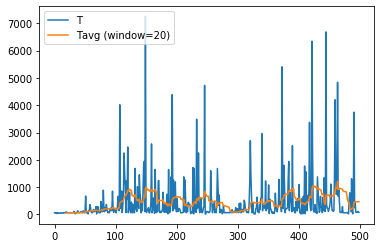

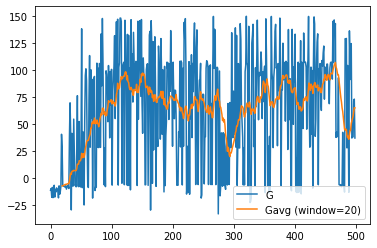

In [6]:
window = 20

plt.plot(range(len(duration)), duration, label='T')
plt.plot(range(window-1, len(duration)), np.convolve(duration, np.ones(window), 'valid') / window, label=f'Tavg (window={window})')
plt.legend()
plt.show()

plt.plot(range(len(returns)), returns, label='G')
plt.plot(range(window-1, len(returns)), np.convolve(returns, np.ones(window), 'valid') / window, label=f'Gavg (window={window})')
plt.legend()
plt.show()

In [ ]:
env.reset()
g = 0
for t in itertools.count():
    a = dqn.policy(get_state(env))
    _, r, done, _ = env.step(a)
    g += max(r, 0)
    if done:
        break
    if t % 10 == 0:
        print(f't={t}, g={g}', env='\b'*100)